# Supply-Demand optimization

Plants distribute power to cities. Given are the distribution costs from each plant to every warehouse, the supply and the operational costs of each plant and the demand of each warehouse.

Variables:
- $X_{i,j}$, $i=1,2,...,N$, $j=1,2,...,M$ how much of plant $i$ goes to warehouse $j$
- $Y_{i}$ $i=1,2,...,N$, binary, 1 if plant $i$ should be used

Constraints:
- $\sum_{j} X_{i, j} \leq S_{i}Y_i \quad \forall i = 1,2,...,N$ the supply cannot be exceeded, where $S_i$ the supply of the plant $i$
- $\sum_{i} x_{i, j}=D_{j} \forall j =1,2,...,M $ the demand has to be satisfied ($D_j$ is the demand of the warehouse $j$)

Objective:

$\min \sum_{i} \sum_{j} C_{i, j} x_{i, j}+\sum_{i} c_{i} y_{i}$

where $C_{i,j}$ is the distribution cost from plant $i$ to warehouse $j$ and $c_i$ is the operational cost of plant $i$.



In [1]:
import pandas as pd
import numpy as np
import pulp
import folium

from folium.plugins import MarkerCluster
from folium.plugins import MousePosition
from folium.features import DivIcon

from math import sin, cos, sqrt, atan2, radians
from supply_demand_opt import SupplyDemand

In [2]:
N = 30
M = 20

coord_init =   [39.553464, 21.759884] #lat, lon

plant_loc =  pd.DataFrame({
    'id_pl' : range(N),
    'lon_pl' : (-1 + 2*np.random.random(N))*0.1 +coord_init[1],
    'lat_pl' : (-1 + 2*np.random.random(N))*0.1 +coord_init[0],
    'cost' : 5_000 + 7_000*np.random.random(N),
    'supply' : 500 + 700*np.random.random(N)
})
warehouse_loc = pd.DataFrame({
    'id_wr' : range(M),
    'lon_wr' : (-1 + 2*np.random.random(M))*0.1 +coord_init[1],
    'lat_wr' : (-1 + 2*np.random.random(M))*0.1 +coord_init[0],
    'demand' : 500 + 700*np.random.random(M)
})



In [3]:
plant_loc.head()

,id_pl,lon_pl,lat_pl,cost,supply
0,0,21.698331,39.567890,8752.283334,1086.234769
1,1,21.732056,39.586146,10363.892490,1112.499978
2,2,21.713844,39.616541,8125.884034,601.081896
3,3,21.726710,39.509052,9625.210635,1003.573235
4,4,21.689503,39.541752,9076.440929,532.907646


In [4]:
warehouse_loc.head()

,id_wr,lon_wr,lat_wr,demand
0,0,21.674719,39.606701,913.263266
1,1,21.749884,39.592771,536.951249
2,2,21.663833,39.465698,1085.655879
3,3,21.783415,39.474805,840.069604
4,4,21.682632,39.478687,713.644686


Folium maps don't render on github, add notebook on nbviewer

In [5]:
site_map = folium.Map(location=coord_init, zoom_start=12)
for i in range(plant_loc.shape[0]):
    plant_coord = [plant_loc.iloc[i,2], plant_loc.iloc[i,1]]
    #circle = folium.Circle(plant_coord,radius=1000,
    #                       color='#d35400', fill=True).add_child(folium.Popup("plant_"+str(plant_loc.iloc[i,0])))
    marker = folium.map.Marker(
        plant_coord,
        # Create an icon as a text label
        icon=DivIcon(
            icon_size=(20,20),
            icon_anchor=(0,0),
            html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % ("plant_"+str(plant_loc.iloc[i,0])),
            )
        )
    #site_map.add_child(circle)
    site_map.add_child(marker)
    
    
for i in range(warehouse_loc.shape[0]):
    warehouse_coord = [warehouse_loc.iloc[i,2], warehouse_loc.iloc[i,1]]
    #circle = folium.Circle(plant_coord,radius=1000,
    #                       color='#d35400', fill=True).add_child(folium.Popup("plant_"+str(plant_loc.iloc[i,0])))
    marker = folium.map.Marker(
        warehouse_coord,
        # Create an icon as a text label
        icon=DivIcon(
            icon_size=(20,20),
            icon_anchor=(0,0),
            html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % ("wr_"+str(warehouse_loc.iloc[i,0])),
            )
        )
    #site_map.add_child(circle)
    site_map.add_child(marker)

marker_cluster = MarkerCluster()
site_map.add_child(marker_cluster)

for index, record in plant_loc.iterrows():
    marker = folium.Marker(location = [record[2], record[1]],
                           icon = folium.Icon(color='white', icon_color="red"),
                           popup = "plant_"+str(record[0]))
    marker_cluster.add_child(marker)

for index, record in warehouse_loc.iterrows():
    marker = folium.Marker(location = [record[2], record[1]],
                           icon = folium.Icon(color='white', icon_color="black"),
                           popup = "wr_"+str(record[0]))
    marker_cluster.add_child(marker)
    
    
site_map


Here is a screenshot of the map

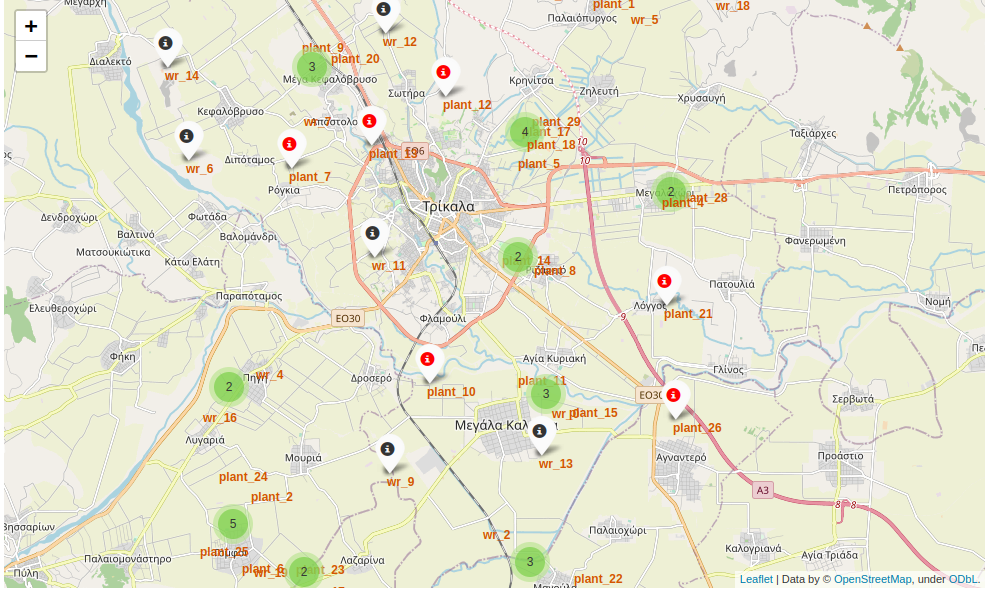

In [6]:
#Transporation cost
def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

c = plant_loc["cost"]
S = plant_loc["supply"]
D = warehouse_loc["demand"]
C = np.zeros((N,M))
for i in range(N):
    for j in range(M):
        C[i,j] = calculate_distance(plant_loc.iloc[i,2],
                                   plant_loc.iloc[i,1],
                                   warehouse_loc.iloc[j,2],
                                   warehouse_loc.iloc[j,1])
        
#Initialize object
supp = SupplyDemand(C, D, S,c)
prob = supp.get_solution()

#Get results
X = {'id_pl' : [],
     'id_wr' : [],
    'value' : []}
Y = {'id_pl': [],
     'value' : []}
for v in prob.variables():
    ids = v.name[2:].split("_")
    if v.name[0] == 'X':
        X['id_pl'].append(int(ids[0]))
        X['id_wr'].append(int(ids[1]))
        X['value'].append(v.varValue)
    else:
        Y['id_pl'].append(int(ids[0]))
        Y['value'].append(v.varValue)

X = pd.DataFrame(X)
Y = pd.DataFrame(Y)
Xfilt = X.loc[X['value']>0].reset_index(drop=False)
#Xfilt = X.copy()
Xfilt = Xfilt.merge(plant_loc, left_on='id_pl', right_on='id_pl')
Xfilt = Xfilt.merge(warehouse_loc, left_on='id_wr', right_on='id_wr')
Xfilt.head()

,index,id_pl,id_wr,value,lon_pl,lat_pl,cost,supply,lon_wr,lat_wr,demand
0,1,0,1,87.898520,21.698331,39.567890,8752.283334,1086.234769,21.749884,39.592771,536.951249
1,421,29,1,437.297000,21.726917,39.607410,7971.609502,1004.441122,21.749884,39.592771,536.951249
2,521,6,1,11.755724,21.776572,39.645047,5388.540796,765.175702,21.749884,39.592771,536.951249
3,3,0,11,998.336250,21.698331,39.567890,8752.283334,1086.234769,21.758500,39.542770,1074.427180
4,23,10,11,76.090931,21.767107,39.528039,7237.643119,613.553421,21.758500,39.542770,1074.427180


In [7]:
site_map = folium.Map(location=coord_init, zoom_start=12)

marker_cluster = MarkerCluster()
site_map.add_child(marker_cluster)

for index, record in plant_loc.iterrows():
    site_status = int(Y[record[0] == Y['id_pl']]['value'])
    marker = folium.Marker(location = [record[2], record[1]],
                           icon = folium.Icon(color='white', icon_color=["red", "green"][site_status]),
                           popup = "plant_"+str(record[0]) +"\n"+ ["closed", "open"][site_status]
                                    + "\n"+ "cost: " + str(round(record[-3])))
    marker_cluster.add_child(marker)

for index, record in warehouse_loc.iterrows():
    marker = folium.Marker(location = [record[2], record[1]],
                           icon = folium.Icon(color='white', icon_color="black"),
                           popup = "wr_"+str(record[0]))
    marker_cluster.add_child(marker)

for index, record in Xfilt.iterrows():
    lines=folium.PolyLine(locations=[list(record[['lat_pl','lon_pl']].values),
                                 list(record[['lat_wr','lon_wr']].values)], weight=3,
                         popup = "supply: " + str(round(record['value'])))
    site_map.add_child(lines)

site_map

Here is a screenshot

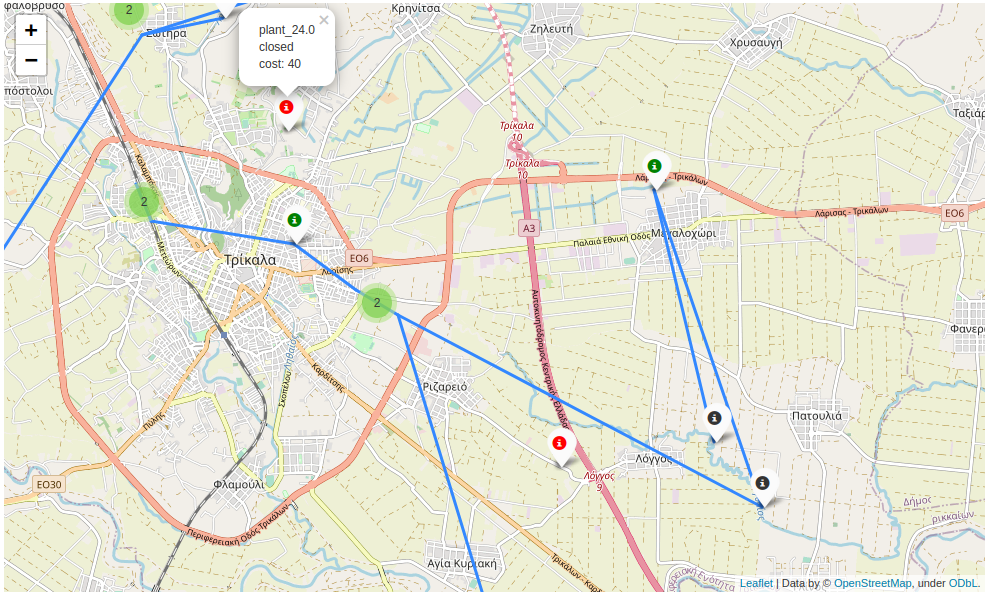